<a href="https://colab.research.google.com/github/WillFerreiraSantos/disserta-o-mestrado/blob/main/BERTimbau_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
!nvidia-smi

Sat Aug  3 20:51:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              47W / 400W |   1341MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForPreTraining
from transformers import AutoModel

model = AutoModelForPreTraining.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

# Calcular o número total de parâmetros no modelo
total_params = sum(p.numel() for p in model.parameters())
print(f"Total de parâmetros no BERTimbau Base: {total_params}")

Total de parâmetros no BERTimbau Base: 109546596


In [ ]:
# Número de camadas ocultas no BERTimbau Base
hidden_layers = model.config.num_hidden_layers
print(f"Número de camadas ocultas no BERTimbau Base: {hidden_layers}")

Número de camadas ocultas no BERTimbau Base: 12


In [ ]:
# Carregar o modelo BERTimbau Base
model = AutoModelForPreTraining.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Imprimir a configuração do modelo
print(model.config)

BertConfig {
  "_name_or_path": "neuralmind/bert-base-portuguese-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 29794
}



In [ ]:
import pandas as pd

# Definir os caminhos dos arquivos CSV
drive_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/BERT Base/Dados-divisão/'
train_path = f'{drive_path}train_data.csv'
val_path = f'{drive_path}val_data.csv'
test_path = f'{drive_path}test_data.csv'

# Carregar os dados divididos para continuar o processamento
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# Verificar as formas dos DataFrames carregados
print("Shape do train_df:", train_df.shape)
print("Shape do val_df:", val_df.shape)
print("Shape do test_df:", test_df.shape)

# Extrair os textos e rótulos das classes do DataFrame
train_texts = train_df['facts'].values
train_labels = train_df['issue_area_label'].values
train_areas = train_df['issue_area'].values

val_texts = val_df['facts'].values
val_labels = val_df['issue_area_label'].values
val_areas = val_df['issue_area'].values

test_texts = test_df['facts'].values
test_labels = test_df['issue_area_label'].values
test_areas = test_df['issue_area'].values

Shape do train_df: (2766, 3)
Shape do val_df: (346, 3)
Shape do test_df: (346, 3)


In [ ]:
from transformers import AutoTokenizer

# Inicializar o tokenizer
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=True)

# Tokenizar os textos de treino, validação e teste
train_texts = train_df['facts'].values
val_texts = val_df['facts'].values
test_texts = test_df['facts'].values

train_labels = train_df['issue_area_label'].values
val_labels = val_df['issue_area_label'].values
test_labels = test_df['issue_area_label'].values

train_ids = [tokenizer.encode(text, max_length=512, padding='max_length', truncation=True) for text in train_texts]
val_ids = [tokenizer.encode(text, max_length=512, padding='max_length', truncation=True) for text in val_texts]
test_ids = [tokenizer.encode(text, max_length=512, padding='max_length', truncation=True) for text in test_texts]

In [ ]:
# Criar máscaras de atenção (attention masks) para as sequências de tokens
train_masks = [[int(token_id > 0) for token_id in token_ids] for token_ids in train_ids]
val_masks = [[int(token_id > 0) for token_id in token_ids] for token_ids in val_ids]
test_masks = [[int(token_id > 0) for token_id in token_ids] for token_ids in test_ids]

# Converter os dados para tensores PyTorch
import torch

train_x = torch.tensor(train_ids)
val_x = torch.tensor(val_ids)
test_x = torch.tensor(test_ids)

train_y = torch.tensor(train_labels)
val_y = torch.tensor(val_labels)
test_y = torch.tensor(test_labels)

train_m = torch.tensor(train_masks)
val_m = torch.tensor(val_masks)
test_m = torch.tensor(test_masks)

In [ ]:
# Exibir tamanhos dos tensores
print("Train x shape:", train_x.shape)
print("Validation x shape:", val_x.shape)
print("Test x shape:", test_x.shape)
print("Train y shape:", train_y.shape)
print("Validation y shape:", val_y.shape)
print("Test y shape:", test_y.shape)
print("Train mask shape:", train_m.shape)
print("Validation mask shape:", val_m.shape)
print("Test mask shape:", test_m.shape)

Train x shape: torch.Size([2766, 512])
Validation x shape: torch.Size([346, 512])
Test x shape: torch.Size([346, 512])
Train y shape: torch.Size([2766])
Validation y shape: torch.Size([346])
Test y shape: torch.Size([346])
Train mask shape: torch.Size([2766, 512])
Validation mask shape: torch.Size([346, 512])
Test mask shape: torch.Size([346, 512])


In [ ]:
# Criar o DataLoader para os conjuntos de treinamento e validação
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Definir o tamanho do lote (batch_size)
batch_size = 32

# Criar TensorDataset para os conjuntos de treinamento e validação
train_data = TensorDataset(train_x, train_m, train_y)
val_data = TensorDataset(val_x, val_m, val_y)

# Criar RandomSampler para o conjunto de treinamento e SequentialSampler para o conjunto de validação
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)

# Criar DataLoader para os conjuntos de treinamento e validação
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
# Carregar o modelo BERTimbau Base para classificação de sequências
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Determinar o número de rótulos (num_labels)
num_labels = max(train_labels) + 1  # Adiciona 1 porque os rótulos geralmente começam de 0

# Carregar o modelo BERTimbau Base para classificação de sequências
model = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased',
                                                      num_labels=num_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

print("Modelo carregado com sucesso.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo carregado com sucesso.


In [ ]:
# Determinar o dispositivo disponível (GPU se disponível, caso contrário, CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Dispositivo de treinamento:", device)

# Mover o modelo para o dispositivo especificado
model = model.to(device)

Dispositivo de treinamento: cuda


In [ ]:
# Função para contar os parâmetros treináveis do modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Exibir o número de parâmetros treináveis e detalhes do modelo
print('Número de parâmetros treináveis:', count_parameters(model), '\n', model)

Número de parâmetros treináveis: 108942361 
 BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
      

In [ ]:
# Listar os nomes dos parâmetros do modelo
[n for n, p in model.named_parameters()]

['bert.embeddings.word_embeddings.weight',
 'bert.embeddings.position_embeddings.weight',
 'bert.embeddings.token_type_embeddings.weight',
 'bert.embeddings.LayerNorm.weight',
 'bert.embeddings.LayerNorm.bias',
 'bert.encoder.layer.0.attention.self.query.weight',
 'bert.encoder.layer.0.attention.self.query.bias',
 'bert.encoder.layer.0.attention.self.key.weight',
 'bert.encoder.layer.0.attention.self.key.bias',
 'bert.encoder.layer.0.attention.self.value.weight',
 'bert.encoder.layer.0.attention.self.value.bias',
 'bert.encoder.layer.0.attention.output.dense.weight',
 'bert.encoder.layer.0.attention.output.dense.bias',
 'bert.encoder.layer.0.attention.output.LayerNorm.weight',
 'bert.encoder.layer.0.attention.output.LayerNorm.bias',
 'bert.encoder.layer.0.intermediate.dense.weight',
 'bert.encoder.layer.0.intermediate.dense.bias',
 'bert.encoder.layer.0.output.dense.weight',
 'bert.encoder.layer.0.output.dense.bias',
 'bert.encoder.layer.0.output.LayerNorm.weight',
 'bert.encoder.layer

In [ ]:
# Taxa de aprendizado e epsilon
learning_rate = 1e-5
adam_epsilon = 1e-8

# Lista de parâmetros que não sofrem decaimento (no_decay)
no_decay = ['bias', 'LayerNorm.weight']

# Configuração dos parâmetros e taxas de decaimento para o otimizador
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Configuração do otimizador AdamW
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Configurar o agendador de taxa de aprendizado (scheduler)
from transformers import get_linear_schedule_with_warmup

# Número de épocas e passos totais
num_epochs = 10
total_steps = len(train_dataloader) * num_epochs

# Configuração do agendador de taxa de aprendizado com aquecimento linear
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
# Configurar sementes aleatórias para reprodutibilidade
import numpy as np
import random

# Definir uma semente fixa para garantir reprodutibilidade
seed_val = 111

# Configurar sementes para bibliotecas aleatórias e PyTorch
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, TensorDataset
import time
import pandas as pd
import os

# Função para calcular previsões e rótulos verdadeiros
def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(tensor.to(device) for tensor in batch)
            inputs, attention_masks, labels = batch
            outputs = model(inputs, attention_mask=attention_masks)

            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            predictions.extend(np.argmax(logits, axis=1).flatten())
            true_labels.extend(label_ids.flatten())

    return predictions, true_labels

# Função para calcular o tempo de uma época
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Função para salvar previsões em arquivo CSV e Excel
def save_predictions_to_file(epoch, phase, true_labels, predictions, directory):
    df = pd.DataFrame({
        'Categoria Real': true_labels,
        'Categoria Prevista': predictions,
        'Correto': np.array(true_labels) == np.array(predictions)
    })

    csv_file_path = os.path.join(directory, f'epoch_{epoch+1}_{phase}_predictions.csv')
    excel_file_path = os.path.join(directory, f'epoch_{epoch+1}_{phase}_predictions.xlsx')

    df.to_csv(csv_file_path, index=False)
    df.to_excel(excel_file_path, index=False)
    print(f'Salvo {phase} previsões da época {epoch+1} em {csv_file_path} e {excel_file_path}')

# Definir diretório para salvar os arquivos
output_directory = '/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Classificações'

# Certificar que o diretório existe
os.makedirs(output_directory, exist_ok=True)

# Convertendo os dados de teste para tensores do PyTorch
test_inputs_tensor = torch.tensor(test_x, dtype=torch.long)
test_masks_tensor = torch.tensor(test_m, dtype=torch.long)
test_labels_tensor = torch.tensor(test_y, dtype=torch.long)

# Criando o Dataset e DataLoader para o conjunto de teste
test_data = TensorDataset(test_inputs_tensor, test_masks_tensor, test_labels_tensor)
test_data_loader = DataLoader(test_data, batch_size=batch_size)

# Inicializando listas para armazenar métricas
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []
validation_precisions = []
validation_recalls = []
validation_f1_scores = []
test_accuracies = []
test_precisions = []
test_recalls = []
test_f1_scores = []
test_losses = []
training_precisions = []
training_recalls = []
training_f1_scores = []

# Iniciando a contagem do tempo total
total_start_time = time.time()

# Loop de treinamento e validação
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = 0
    train_correct = 0
    train_total = 0
    train_predictions = []
    train_true_labels = []

    # Treinamento
    model.train()
    for step, (mini_batch_x, mini_batch_m, mini_batch_y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        mini_batch_x = mini_batch_x.to(device)
        mini_batch_m = mini_batch_m.to(device)
        mini_batch_y = mini_batch_y.to(device)

        outputs = model(mini_batch_x, attention_mask=mini_batch_m, labels=mini_batch_y)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        train_total += mini_batch_y.size(0)
        train_correct += (predicted == mini_batch_y).sum().item()
        train_predictions.extend(predicted.detach().cpu().numpy())
        train_true_labels.extend(mini_batch_y.detach().cpu().numpy())

    train_loss /= len(train_dataloader)
    train_accuracy = 100 * train_correct / train_total
    training_losses.append(train_loss)
    training_accuracies.append(train_accuracy)

    # Salvar previsões de treinamento
    save_predictions_to_file(epoch, 'train', train_true_labels, train_predictions, output_directory)

    # Calcular Precision, Recall, F1-Score para treinamento
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(train_true_labels, train_predictions, average='weighted', zero_division=0)
    training_precisions.append(train_precision)
    training_recalls.append(train_recall)
    training_f1_scores.append(train_f1)

    # Validação
    validation_loss = 0
    validation_correct = 0
    validation_total = 0
    validation_predictions = []
    validation_true_labels = []
    model.eval()
    with torch.no_grad():
        for mini_batch_x, mini_batch_m, mini_batch_y in val_dataloader:
            mini_batch_x = mini_batch_x.to(device)
            mini_batch_m = mini_batch_m.to(device)
            mini_batch_y = mini_batch_y.to(device)
            outputs = model(mini_batch_x, attention_mask=mini_batch_m, labels=mini_batch_y)
            loss = outputs.loss
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            validation_total += mini_batch_y.size(0)
            validation_correct += (predicted == mini_batch_y).sum().item()
            validation_predictions.extend(predicted.detach().cpu().numpy())
            validation_true_labels.extend(mini_batch_y.detach().cpu().numpy())

    validation_loss /= len(val_dataloader)
    validation_accuracy = 100 * validation_correct / validation_total
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    # Salvar previsões de validação
    save_predictions_to_file(epoch, 'val', validation_true_labels, validation_predictions, output_directory)

    # Calcular Precision, Recall, F1-Score para validação
    validation_precision, validation_recall, validation_f1, _ = precision_recall_fscore_support(validation_true_labels, validation_predictions, average='weighted', zero_division=0)
    validation_precisions.append(validation_precision)
    validation_recalls.append(validation_recall)
    validation_f1_scores.append(validation_f1)

    # Calcular métricas para o conjunto de teste após cada época
    test_loss = 0
    test_predictions, test_true_labels = get_predictions_and_labels(model, test_data_loader, device)
    with torch.no_grad():
        for mini_batch_x, mini_batch_m, mini_batch_y in test_data_loader:
            mini_batch_x = mini_batch_x.to(device)
            mini_batch_m = mini_batch_m.to(device)
            mini_batch_y = mini_batch_y.to(device)
            outputs = model(mini_batch_x, attention_mask=mini_batch_m, labels=mini_batch_y)
            loss = outputs.loss
            test_loss += loss.item()

    test_loss /= len(test_data_loader)
    test_losses.append(test_loss)

    # Calculando as métricas de precisão, recall e f1 para o conjunto de teste
    test_accuracy = accuracy_score(test_true_labels, test_predictions)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_true_labels, test_predictions, average='weighted', zero_division=0)

    test_accuracies.append(test_accuracy)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1_scores.append(test_f1)

    # Salvar previsões de teste
    save_predictions_to_file(epoch, 'test', test_true_labels, test_predictions, output_directory)

    # Final da época
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Imprimir as métricas com espaçamento melhorado
    print(f'Epoch: {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.6f} | Train Accuracy: {train_accuracy:.2f}%')
    print(f'Train Precision: {train_precision:.2f} | Train Recall: {train_recall:.2f} | Train F1: {train_f1:.2f}')
    print(f'Validation Loss: {validation_loss:.6f} | Validation Accuracy: {validation_accuracy:.2f}%')
    print(f'Validation Precision: {validation_precision:.2f} | Validation Recall: {validation_recall:.2f} | Validation F1: {validation_f1:.2f}')
    print(f'Test Loss: {test_loss:.6f} | Test Accuracy: {test_accuracy:.2f}%')
    print(f'Test Precision: {test_precision:.2f} | Test Recall: {test_recall:.2f} | Test F1: {test_f1:.2f}')
    print(f'Epoch Duration: {epoch_mins}m {epoch_secs}s\n' + '-'*100)

# Calculando o tempo total de treinamento
total_end_time = time.time()
total_mins, total_secs = epoch_time(total_start_time, total_end_time)
print(f'Tempo total de treinamento: {total_mins}m {total_secs}s')

<ipython-input-63-8f0e0e1b40f3>:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs_tensor = torch.tensor(test_x, dtype=torch.long)
<ipython-input-63-8f0e0e1b40f3>:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_masks_tensor = torch.tensor(test_m, dtype=torch.long)
<ipython-input-63-8f0e0e1b40f3>:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels_tensor = torch.tensor(test_y, dtype=torch.long)


Salvo train previsões da época 1 em /content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Classificações/epoch_1_train_predictions.csv e /content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Classificações/epoch_1_train_predictions.xlsx
Salvo val previsões da época 1 em /content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Classificações/epoch_1_val_predictions.csv e /content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Classificações/epoch_1_val_predictions.xlsx
Salvo test previsões da época 1 em /content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Classificações/epoch_1_test_predictions.csv e /content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Classificações/epoch_1_test_predictions.xlsx
Epoch: 1/10
Train Loss: 2.563163 | Train Accuracy: 36.23%
Train Precision: 0.30 | Train Recall: 0.36 | Train F1: 0.26
Validation Loss: 1.998586 | Validation Accuracy: 54.91%
Validation Precision: 0.41 | Valid

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, matthews_corrcoef
import pandas as pd

# Mapeamento dos nomes das classes
class_names = {
    1: 'AGRAVO',
    2: 'ALVARA-JUDICIAL-LIBERACAO-DE-CORPO',
    3: 'APELACAO',
    4: 'CONSIGNACAO-EM-PAGAMENTO',
    5: 'CONTRARRAZOES-AO-AGRAVO',
    6: 'CUMPRIMENTO-DE-SETENCA',
    7: 'DISSOLUCAO-DE-CONDOMINIO',
    8: 'EMBARGOS',
    9: 'EXCECAO-DE-PRE-EXECUTIVIDADE',
    10: 'EXTINCAO-DE-PUNIBILIDADE',
    11: 'HABEAS-CORPUS',
    12: 'IMPUGNACAO',
    13: 'INDENIZATORIAS',
    14: 'INDULTO-COMUTACAO',
    15: 'INTIMACAO-NEGATIVA',
    16: 'LIVRAMENTO-CONDICIONAL',
    17: 'OFICIOS',
    18: 'PROGRESSAO-DE-REGIME',
    19: 'REGISTRO-CIVIL',
    20: 'REMICAO-DE-PENA',
    21: 'SAIDA-TEMPORARIA',
    22: 'TRANSFERENCIA-DE-EXECUCAO',
    23: 'UNIFICACAO-DE-PENAS',
    24: 'USUCAPIAO'
}

# Função para obter previsões e rótulos verdadeiros
def get_predictions_and_labels(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in data_loader:
            batch = tuple(tensor.to(device) for tensor in batch)
            inputs, attention_masks, labels = batch
            outputs = model(inputs, attention_mask=attention_masks)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return np.array(predictions), np.array(true_labels)

# Gerar previsões e rótulos verdadeiros no conjunto de teste
test_predictions, test_true_labels = get_predictions_and_labels(model, test_data_loader, device)

# Calcular as probabilidades das classes para AUC-ROC
probs = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        batch = tuple(tensor.to(device) for tensor in batch)
        inputs, attention_masks, _ = batch
        outputs = model(inputs, attention_mask=attention_masks)
        logits = outputs.logits
        probs.extend(torch.softmax(logits, dim=1).cpu().numpy())

# Converter probabilidades em numpy array
probs = np.array(probs)

# Garantir que o número de classes em y_true corresponda ao número de colunas em y_score
num_classes = probs.shape[1]
unique_labels = np.unique(test_true_labels)

# Ajustar test_true_labels para garantir que abrange todas as classes
if len(unique_labels) < num_classes:
    missing_labels = set(range(num_classes)) - set(unique_labels)
    for label in missing_labels:
        test_true_labels = np.append(test_true_labels, label)
        dummy_probs = np.zeros((1, num_classes))
        dummy_probs[0, label] = 1
        probs = np.vstack([probs, dummy_probs])

# Agora ajustar test_predictions para garantir que abrange todas as classes
if len(unique_labels) < num_classes:
    for label in missing_labels:
        test_predictions = np.append(test_predictions, label)

# Garantir que as dimensões de test_true_labels e probs sejam iguais
min_len = min(len(test_true_labels), len(probs))
test_true_labels = test_true_labels[:min_len]
test_predictions = test_predictions[:min_len]
probs = probs[:min_len]

# Calcular AUC-ROC para cada classe
auc_roc = roc_auc_score(test_true_labels, probs, multi_class='ovr')

# Calcular AUC-PR para cada classe individualmente e calcular a média ponderada
class_weights = []
class_auc_prs = []

for i in range(num_classes):
    class_true_labels = (test_true_labels == i).astype(int)
    class_probs = probs[:, i]
    class_auc_pr = average_precision_score(class_true_labels, class_probs)
    class_auc_prs.append(class_auc_pr)
    class_weights.append(np.sum(class_true_labels))

# Calcular a média ponderada de AUC-PR
auc_pr = np.average(class_auc_prs, weights=class_weights)

# Calcular MCC (apenas se os comprimentos forem consistentes)
mcc = matthews_corrcoef(test_true_labels, test_predictions)

# Adicionar métricas gerais ao dicionário de métricas consolidadas
weighted_avg_metrics = {
    'AUC-ROC': auc_roc,
    'AUC-PR': auc_pr,
    'MCC': mcc
}

# Exibir métricas gerais
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUC-PR: {auc_pr:.4f}")
print(f"MCC: {mcc:.4f}")

# Calcular métricas para cada classe
class_metrics = []
for i in range(1, num_classes + 1):  # Ajustando o índice para começar de 1
    if i in class_names:  # Verificar se o índice está no dicionário class_names
        class_true_labels = (test_true_labels == i).astype(int)
        class_probs = probs[:, i - 1]  # Ajustando o índice para corresponder a probabilidade correta
        if len(np.unique(class_true_labels)) > 1:  # Verificar se há pelo menos duas classes presentes
            class_auc_roc = roc_auc_score(class_true_labels, class_probs)
        else:
            class_auc_roc = float('nan')  # Definir como nan se não houver classes suficientes
        class_auc_pr = class_auc_prs[i - 1]  # Ajustando o índice para corresponder ao AUC-PR correto
        class_mcc = matthews_corrcoef(class_true_labels, (test_predictions == i).astype(int))

        class_metrics.append({
            'Class': class_names[i],
            'AUC-ROC': class_auc_roc,
            'AUC-PR': class_auc_pr,
            'MCC': class_mcc
        })

        print(f"\nClass {class_names[i]} Metrics:")
        print(f"AUC-ROC: {class_auc_roc:.4f}")
        print(f"AUC-PR: {class_auc_pr:.4f}")
        print(f"MCC: {class_mcc:.4f}")

# Converter para DataFrame para exibição
class_metrics_df = pd.DataFrame(class_metrics)
metrics_df = pd.DataFrame([weighted_avg_metrics])

# Exibir métricas consolidadas
print("\nMétricas do Modelo:")
print(metrics_df)

# Salvar métricas consolidadas em CSV
metrics_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Training-Metrics/consolidated_metrics.csv', index=False)

# Salvar métricas por classe em CSV
class_metrics_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Training-Metrics/class_metrics.csv', index=False)

AUC-ROC: 0.9920
AUC-PR: 0.9692
MCC: 0.9185

Class AGRAVO Metrics:
AUC-ROC: 0.2452
AUC-PR: 1.0000
MCC: 0.9607

Class ALVARA-JUDICIAL-LIBERACAO-DE-CORPO Metrics:
AUC-ROC: 0.7948
AUC-PR: 0.9933
MCC: 1.0000

Class APELACAO Metrics:
AUC-ROC: 0.3788
AUC-PR: 1.0000
MCC: 1.0000

Class CONSIGNACAO-EM-PAGAMENTO Metrics:
AUC-ROC: 0.7139
AUC-PR: 1.0000
MCC: 1.0000

Class CONTRARRAZOES-AO-AGRAVO Metrics:
AUC-ROC: 0.9942
AUC-PR: 1.0000
MCC: 1.0000

Class CUMPRIMENTO-DE-SETENCA Metrics:
AUC-ROC: 0.7343
AUC-PR: 1.0000
MCC: 0.9646

Class DISSOLUCAO-DE-CONDOMINIO Metrics:
AUC-ROC: 0.9477
AUC-PR: 0.9529
MCC: 0.8153

Class EMBARGOS Metrics:
AUC-ROC: 0.3823
AUC-PR: 1.0000
MCC: 0.9822

Class EXCECAO-DE-PRE-EXECUTIVIDADE Metrics:
AUC-ROC: 0.8757
AUC-PR: 0.9804
MCC: 1.0000

Class EXTINCAO-DE-PUNIBILIDADE Metrics:
AUC-ROC: 0.3539
AUC-PR: 1.0000
MCC: 0.8958

Class HABEAS-CORPUS Metrics:
AUC-ROC: 0.5523
AUC-PR: 0.9832
MCC: 1.0000

Class IMPUGNACAO Metrics:
AUC-ROC: 0.2870
AUC-PR: 1.0000
MCC: 0.9331

Class INDENI

In [ ]:
import pandas as pd

# Convertendo métricas de acurácia, precisão, recall, F1-Score para porcentagem quando aplicável
metrics_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Training Loss': training_losses,
    'Training Accuracy': [acc * 100 for acc in training_accuracies],
    'Training Precision': [prec * 100 for prec in training_precisions],
    'Training Recall': [rec * 100 for rec in training_recalls],
    'Training F1-Score': [f1 * 100 for f1 in training_f1_scores],
    'Validation Loss': validation_losses,
    'Validation Accuracy': [acc * 100 for acc in validation_accuracies],
    'Validation Precision': [prec * 100 for prec in validation_precisions],
    'Validation Recall': [rec * 100 for rec in validation_recalls],
    'Validation F1-Score': [f1 * 100 for f1 in validation_f1_scores],
    'Test Loss': test_losses,
    'Test Accuracy': [acc * 100 for acc in test_accuracies],
    'Test Precision': [prec * 100 for prec in test_precisions],
    'Test Recall': [rec * 100 for rec in test_recalls],
    'Test F1-Score': [f1 * 100 for f1 in test_f1_scores],
})

# Salvar o arquivo CSV
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Training-Metrics/training_metrics.csv'

# Salvar o DataFrame em um arquivo CSV
metrics_df.to_csv(csv_file_path, index=False)

# Verificar se o arquivo foi salvo com sucesso
print(f"Metrics saved to: {csv_file_path}")

Metrics saved to: /content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Training-Metrics/training_metrics.csv


In [ ]:
# Verificar o uso de GPU
if torch.cuda.is_available():
    gpu_memory_allocated = torch.cuda.memory_allocated(0) / 1024.0 / 1024.0  # Em megabytes
    gpu_memory_reserved = torch.cuda.memory_reserved(0) / 1024.0 / 1024.0  # Em megabytes
    print(f'Memória da GPU Alocada: {gpu_memory_allocated:.2f} MB')
    print(f'Memória da GPU Reservada: {gpu_memory_reserved:.2f} MB')

Memória da GPU Alocada: 1703.21 MB
Memória da GPU Reservada: 11530.00 MB


In [ ]:
# Salvar o modelo treinado, tokenizer e perdas em arquivos
import pickle
import os

# Diretório de saída para salvar os arquivos
out_dir = '/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Modelo-treinado-tokenizer-e-perdas-em-arquivos'

# Criar o diretório se não existir
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Salvar o modelo treinado e o tokenizer
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)

# Salvar as perdas de treinamento e validação em arquivos pickle
with open(out_dir + '/train_losses.pkl', 'wb') as f:
    pickle.dump(training_losses, f)

with open(out_dir + '/val_losses.pkl', 'wb') as f:
    pickle.dump(validation_losses, f)

In [ ]:
# Carregar modelo treinado, tokenizer e perdas a partir dos arquivos salvos
out_dir = '/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Modelo-treinado-tokenizer-e-perdas-em-arquivos'

# Carregar o modelo treinado
model = BertForSequenceClassification.from_pretrained(out_dir)

# Configurar o dispositivo (GPU se disponível, caso contrário, CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Carregar as perdas de treinamento e validação a partir dos arquivos pickle
with open(out_dir + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)

with open(out_dir + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

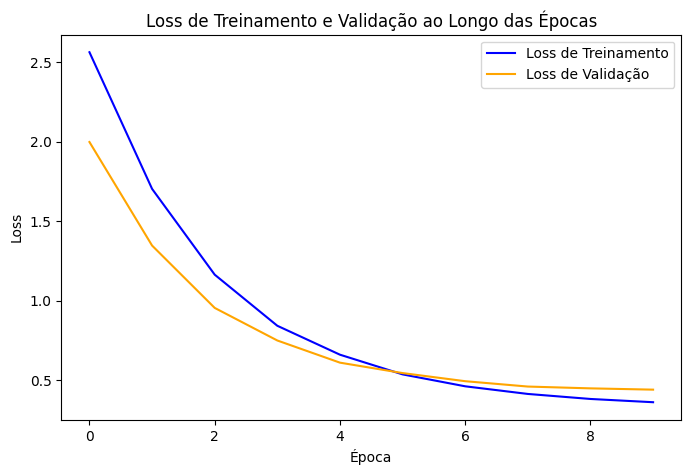

In [ ]:
# Plotar as perdas de treinamento e validação ao longo das épocas (Loss)
from matplotlib import pyplot as plt
%matplotlib inline

# Plotar train_losses e val_losses no mesmo gráfico
plt.figure(figsize=(8, 5))  # Redimensionado para padrões de publicação

plt.plot(train_losses, label='Loss de Treinamento', color='blue')
plt.plot(val_losses, label='Loss de Validação', color='orange')

plt.title('Loss de Treinamento e Validação ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Avaliar o modelo no conjunto de teste
batch_size = 32

# Criar um conjunto de dados de teste
test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

outputs = []

# Desativar gradientes para economizar memória e acelerar a inferência
with torch.no_grad():
    model.eval()

    # Loop através dos lotes de teste
    for k, (mb_x, mb_m) in enumerate(test_dataloader):
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)

        # Obter saída do modelo
        output = model(mb_x, attention_mask=mb_m)

        # Adicionar a saída ao tensor de resultados
        outputs.append(output[0].to('cpu'))

# Concatenar os resultados em um único tensor
outputs = torch.cat(outputs)

In [ ]:
# Calcular as previsões do modelo no conjunto de teste
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()

In [ ]:
# Calcular e imprimir a acurácia do modelo no conjunto de teste
test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print("Precisão do teste:", test_accuracy)

Precisão do teste: 0.9248554913294798


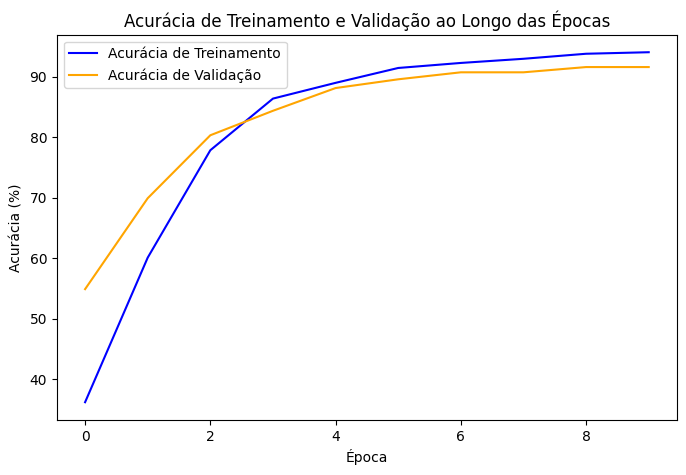

In [ ]:
# Plotar as acurácias de treinamento e validação (Acurácia)
plt.figure(figsize=(8, 5))
plt.plot(training_accuracies, label='Acurácia de Treinamento', color='blue')
plt.plot(validation_accuracies, label='Acurácia de Validação', color='orange')
plt.title('Acurácia de Treinamento e Validação ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# Carregar os dados para obter os rótulos e nomes das categorias
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Defesa final/Dados DPE-GO/Dados-DPE-GO.xlsx - Dados-DPE-GO (1).csv')

# Lista de rótulos únicos e nomes de destino
unique_labels = df['issue_area_label'].unique()
target_names = df['issue_area'].unique()

# Ordenar target_names de acordo com unique_labels
target_names_ordered = [df[df['issue_area_label'] == label]['issue_area'].iloc[0] for label in unique_labels]

# Função para converter métricas para porcentagem
def convert_to_percentage(df):
    df['precision'] = df['precision'].apply(lambda x: f'{x * 100:.2f}%')
    df['recall'] = df['recall'].apply(lambda x: f'{x * 100:.2f}%')
    df['f1-score'] = df['f1-score'].apply(lambda x: f'{x * 100:.2f}%')
    return df

# Gerar o relatório de classificação para treino
train_report_dict = classification_report(train_true_labels, train_predictions, labels=unique_labels, target_names=target_names_ordered, output_dict=True, zero_division=0)
train_report_df = pd.DataFrame(train_report_dict).transpose()
train_report_df = convert_to_percentage(train_report_df)

# Mova 'micro avg', 'macro avg' e 'weighted avg' para o final
train_report_df_reordered = pd.concat([train_report_df[~train_report_df.index.isin(['micro avg', 'macro avg', 'weighted avg'])], train_report_df[train_report_df.index.isin(['micro avg', 'macro avg', 'weighted avg'])]])

# Ordenar por múltiplas métricas (do melhor resultado para o pior)
train_report_df_reordered = train_report_df_reordered.sort_values(by=['f1-score', 'precision', 'recall'], ascending=[False, False, False])

print("Relatório de Classificação de Treino Ordenado:")
print(train_report_df_reordered)

# Gerar o relatório de classificação para validação
val_report_dict = classification_report(validation_true_labels, validation_predictions, labels=unique_labels, target_names=target_names_ordered, output_dict=True, zero_division=0)
val_report_df = pd.DataFrame(val_report_dict).transpose()
val_report_df = convert_to_percentage(val_report_df)

# Mova 'micro avg', 'macro avg' e 'weighted avg' para o final
val_report_df_reordered = pd.concat([val_report_df[~val_report_df.index.isin(['micro avg', 'macro avg', 'weighted avg'])], val_report_df[val_report_df.index.isin(['micro avg', 'macro avg', 'weighted avg'])]])

# Ordenar por múltiplas métricas (do melhor resultado para o pior)
val_report_df_reordered = val_report_df_reordered.sort_values(by=['f1-score', 'precision', 'recall'], ascending=[False, False, False])

print("\nRelatório de Classificação de Validação Ordenado:")
print(val_report_df_reordered)

# Gerar o relatório de classificação para teste
test_report_dict = classification_report(true_values, predicted_values, labels=unique_labels, target_names=target_names_ordered, output_dict=True, zero_division=0)
test_report_df = pd.DataFrame(test_report_dict).transpose()
test_report_df = convert_to_percentage(test_report_df)

# Ordenar por múltiplas métricas (do melhor resultado para o pior)
test_report_df = test_report_df.sort_values(by=['f1-score', 'precision', 'recall'], ascending=[False, False, False])

print("\nRelatório de Classificação de Teste Ordenado:")
print(test_report_df)

# Calcular a acurácia para o conjunto de treino
train_accuracy = accuracy_score(train_true_labels, train_predictions)

# Calcular a acurácia para o conjunto de validação
val_accuracy = accuracy_score(validation_true_labels, validation_predictions)

# Calcular a acurácia para o conjunto de teste
test_accuracy = accuracy_score(true_values, predicted_values)

# Incluir acurácia no DataFrame de relatório de classificação
train_report_df_reordered.loc['accuracy'] = train_accuracy
val_report_df_reordered.loc['accuracy'] = val_accuracy
test_report_df.loc['accuracy'] = test_accuracy

# Imprimir acurácia
print("\nAcurácia para Treino:", train_accuracy)
print("Acurácia para Validação:", val_accuracy)
print("Acurácia para Teste:", test_accuracy)

# Caminhos para salvar os arquivos CSV
train_csv_file_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Relatório-de-classificação-para-treino/Train_Classification_Report.csv'
val_csv_file_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Relatório-de-classificação-para-validação/Val_Classification_Report.csv'
test_csv_file_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Relatório-de-classificação-para-teste/Test_Classification_Report.csv'

# Salvar os DataFrames em arquivos CSV
train_report_df_reordered.to_csv(train_csv_file_path, index=True)
val_report_df_reordered.to_csv(val_csv_file_path, index=True)
test_report_df.to_csv(test_csv_file_path, index=True)

print("\nRelatórios salvos em CSV:")
print("Treino:", train_csv_file_path)
print("Validação:", val_csv_file_path)
print("Teste:", test_csv_file_path)

Relatório de Classificação de Treino Ordenado:
                                   precision   recall f1-score      support
EXCECAO-DE-PRE-EXECUTIVIDADE          98.57%  100.00%   99.28%    69.000000
EMBARGOS                              98.76%   98.35%   98.56%   243.000000
IMPUGNACAO                            98.25%   98.82%   98.53%   340.000000
USUCAPIAO                            100.00%   97.06%   98.51%    34.000000
CUMPRIMENTO-DE-SETENCA               100.00%   96.67%   98.31%   120.000000
HABEAS-CORPUS                        100.00%   95.45%   97.67%    22.000000
AGRAVO                                97.46%   97.73%   97.60%   353.000000
OFICIOS                               95.12%  100.00%   97.50%   117.000000
REGISTRO-CIVIL                        95.43%   99.47%   97.41%   189.000000
EXTINCAO-DE-PUNIBILIDADE              94.02%   98.25%   96.09%   400.000000
accuracy                              94.07%   94.07%   94.07%     0.940709
weighted avg                          93.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Função para calcular previsões e rótulos verdadeiros
def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(tensor.to(device) for tensor in batch)
            inputs, attention_masks, labels = batch
            outputs = model(inputs, attention_mask=attention_masks)

            logits = outputs.logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            predictions.extend(np.argmax(logits, axis=1).flatten())
            true_labels.extend(label_ids.flatten())

    return predictions, true_labels

# Lista com os nomes das categorias
target_names = [
    'EXTINCAO-DE-PUNIBILIDADE', 'AGRAVO', 'IMPUGNACAO', 'EMBARGOS', 'APELACAO', 'REGISTRO-CIVIL',
    'LIVRAMENTO-CONDICIONAL', 'INDULTO-COMUTACAO', 'CUMPRIMENTO-DE-SETENCA', 'OFICIOS', 'INDENIZATORIAS',
    'EXCECAO-DE-PRE-EXECUTIVIDADE', 'TRANSFERENCIA-DE-EXECUCAO', 'USUCAPIAO', 'UNIFICACAO-DE-PENAS',
    'HABEAS-CORPUS', 'INTIMACAO-NEGATIVA', 'DISSOLUCAO-DE-CONDOMINIO', 'REMICAO-DE-PENA', 'PROGRESSAO-DE-REGIME',
    'CONSIGNACAO-EM-PAGAMENTO', 'CONTRARRAZOES-AO-AGRAVO', 'SAIDA-TEMPORARIA', 'ALVARA-JUDICIAL-LIBERACAO-DE-CORPO'
]

# Gerar previsões e rótulos verdadeiros
test_predictions, test_true_labels = get_predictions_and_labels(model, test_data_loader, device)

# Calcular e imprimir as métricas
accuracy = accuracy_score(test_true_labels, test_predictions)
precision = precision_score(test_true_labels, test_predictions, average="macro")
recall = recall_score(test_true_labels, test_predictions, average="macro")
f1 = f1_score(test_true_labels, test_predictions, average="macro")

print("Accuracy     ", accuracy)
print("Precision    ", precision)
print("Recall       ", recall)
print("F1           ", f1)

# Gerar e imprimir o relatório de classificação
report = classification_report(test_true_labels, test_predictions, target_names=target_names, digits=4)
print("Relatório de classificação para o conjunto de teste:\n")
print(report)

Accuracy      0.9248554913294798
Precision     0.7955691562800831
Recall        0.7716435635837913
F1            0.773896275157855
Relatório de classificação para o conjunto de teste:

                                    precision    recall  f1-score   support

          EXTINCAO-DE-PUNIBILIDADE     0.9767    0.9545    0.9655        44
                            AGRAVO     1.0000    1.0000    1.0000         1
                        IMPUGNACAO     1.0000    1.0000    1.0000        30
                          EMBARGOS     1.0000    1.0000    1.0000         1
                          APELACAO     1.0000    1.0000    1.0000         1
                    REGISTRO-CIVIL     1.0000    0.9333    0.9655        15
            LIVRAMENTO-CONDICIONAL     1.0000    0.6667    0.8000         3
                 INDULTO-COMUTACAO     1.0000    0.9677    0.9836        31
            CUMPRIMENTO-DE-SETENCA     1.0000    1.0000    1.0000         9
                           OFICIOS     0.9020    0.920

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:14

Resultados da validação cruzada:
Iteração 1: 0.6209
Iteração 2: 0.6065
Iteração 3: 0.6751
Iteração 4: 0.6643
Iteração 5: 0.5993
Iteração 6: 0.6245
Iteração 7: 0.6159
Iteração 8: 0.6667
Iteração 9: 0.6196
Iteração 10: 0.6268


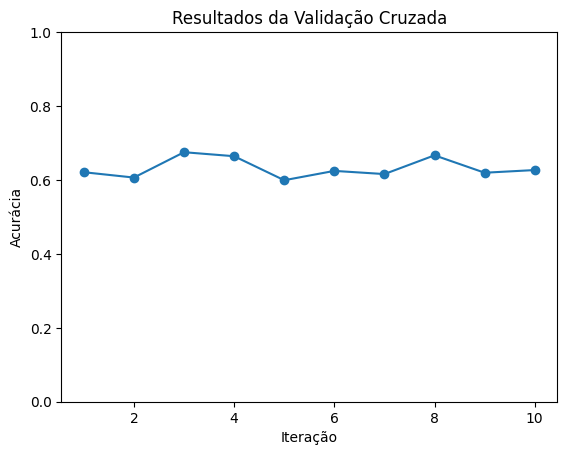

Média da acurácia: 0.6320
Desvio padrão da acurácia: 0.0254


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Inicializar o classificador de RandomForest
classifier = RandomForestClassifier()

# Aplicar validação cruzada no conjunto de treinamento
scores = cross_val_score(classifier, train_x, train_y, cv=10)

# Imprimir os resultados
print("Resultados da validação cruzada:")
for i, score in enumerate(scores, 1):
    print(f"Iteração {i}: {score:.4f}")

# Plotar os resultados
plt.plot(range(1, len(scores) + 1), scores, marker='o')
plt.title('Resultados da Validação Cruzada')
plt.xlabel('Iteração')
plt.ylabel('Acurácia')
plt.ylim(0, 1)  # Ajustar o eixo y para uma melhor visualização
plt.show()

# Exibir a média e o desvio padrão das acurácias
print(f'Média da acurácia: {scores.mean():.4f}')
print(f'Desvio padrão da acurácia: {scores.std():.4f}')

Matriz de confusão, sem normalização


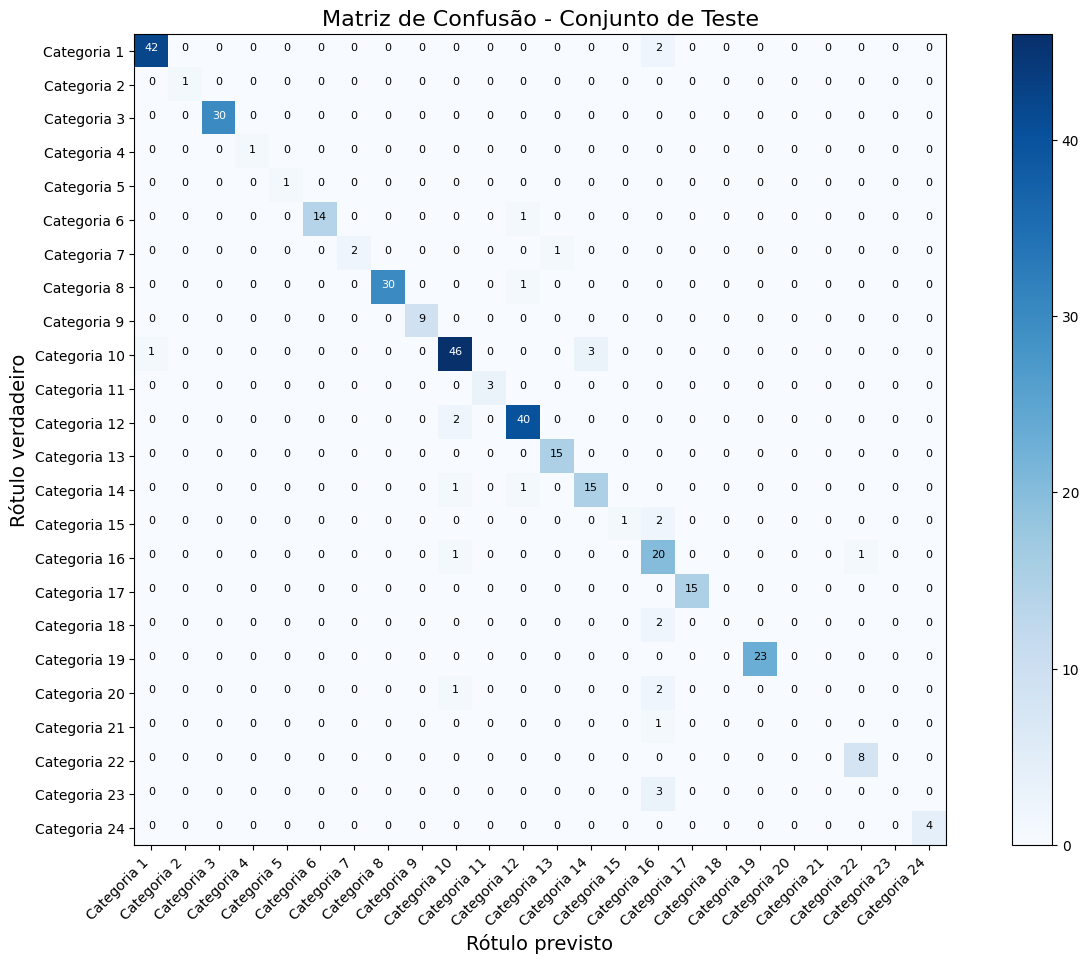

Matriz de confusão salva em CSV: /content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/matriz-de-confusão-results/matriz_de_confusao.csv
Matriz de confusão salva em Excel: /content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/matriz-de-confusão-results/matriz_de_confusao.xlsx
Matriz de confusão normalizada


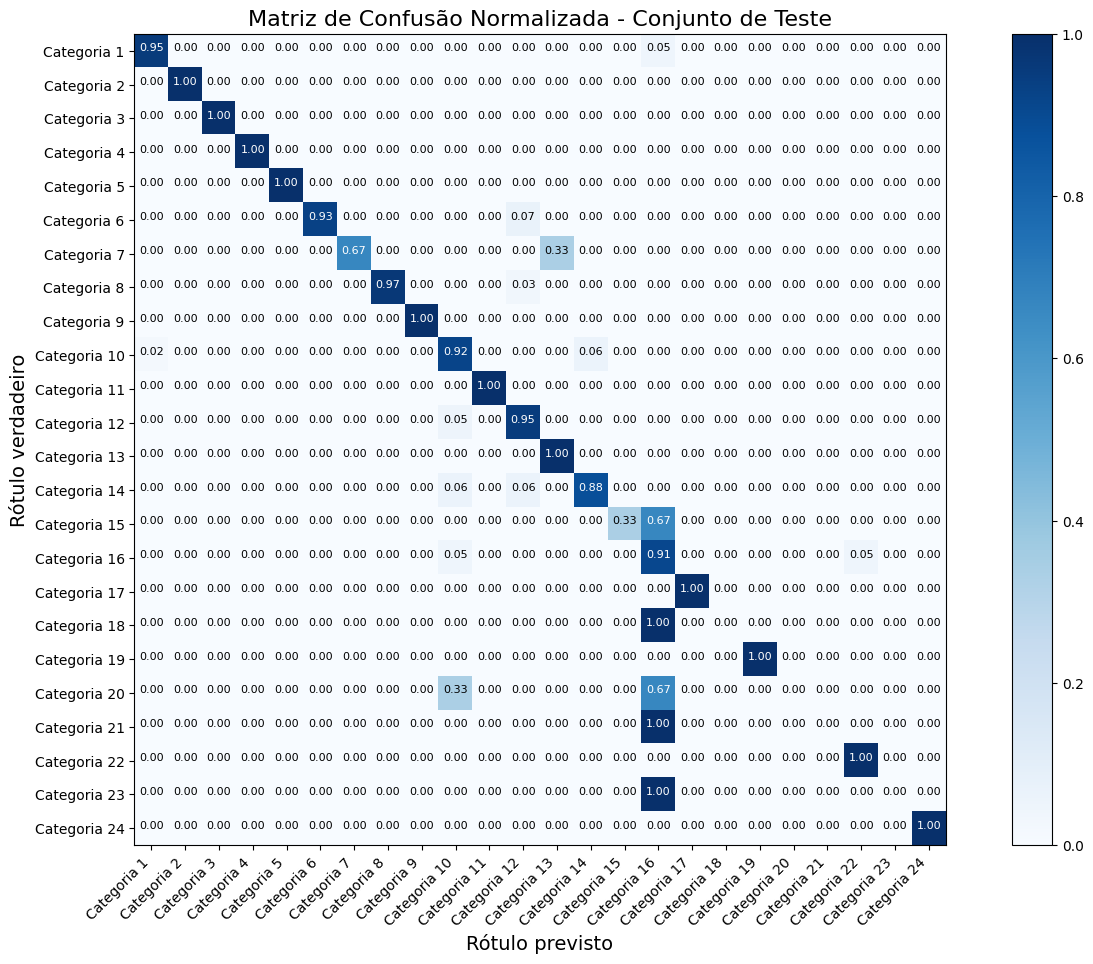

Matriz de confusão normalizada salva em CSV: /content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/matriz-de-confusão-results/matriz_de_confusao_normalizada.csv
Matriz de confusão normalizada salva em Excel: /content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/matriz-de-confusão-results/matriz_de_confusao_normalizada.xlsx


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusão', cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada configurando `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão, sem normalização')

    plt.figure(figsize=(14, 10))  # Aumentar ainda mais o tamanho da figura
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)  # Ajustar o tamanho da fonte do título
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right', fontsize=10)  # Rotacionar rótulos do eixo x e ajustar o tamanho da fonte
    plt.yticks(tick_marks, classes, fontsize=10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=8)  # Ajustar o tamanho da fonte para as anotações

    plt.ylabel('Rótulo verdadeiro', fontsize=14)
    plt.xlabel('Rótulo previsto', fontsize=14)
    plt.tight_layout(pad=2)  # Ajustar o layout com padding
    plt.show()  # Mostrar a figura

# Calcular a matriz de confusão
cm_test = confusion_matrix(true_values, predicted_values)

# Garantir que todas as classes sejam representadas
unique_labels = np.unique(np.concatenate((true_values, predicted_values)))
target_names = ['Categoria {}'.format(i) for i in unique_labels]

# Configurar opções de impressão para precisão de ponto flutuante
np.set_printoptions(precision=2)

# Plotar e salvar a matriz de confusão sem normalização
plot_confusion_matrix(cm_test, target_names, normalize=False, title='Matriz de Confusão - Conjunto de Teste')

# Salvar a matriz de confusão sem normalização em CSV e Excel
confusion_df = pd.DataFrame(cm_test, index=target_names, columns=target_names)
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/matriz-de-confusão-results/matriz_de_confusao.csv'
excel_file_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/matriz-de-confusão-results/matriz_de_confusao.xlsx'
confusion_df.to_csv(csv_file_path)
confusion_df.to_excel(excel_file_path)
print(f"Matriz de confusão salva em CSV: {csv_file_path}")
print(f"Matriz de confusão salva em Excel: {excel_file_path}")

# Calcular a matriz de confusão normalizada
cm_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

# Plotar e salvar a matriz de confusão normalizada
plot_confusion_matrix(cm_normalized, target_names, normalize=True, title='Matriz de Confusão Normalizada - Conjunto de Teste')

# Salvar a matriz de confusão normalizada em CSV e Excel
confusion_normalized_df = pd.DataFrame(cm_normalized, index=target_names, columns=target_names)
normalized_csv_file_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/matriz-de-confusão-results/matriz_de_confusao_normalizada.csv'
normalized_excel_file_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/matriz-de-confusão-results/matriz_de_confusao_normalizada.xlsx'
confusion_normalized_df.to_csv(normalized_csv_file_path)
confusion_normalized_df.to_excel(normalized_excel_file_path)
print(f"Matriz de confusão normalizada salva em CSV: {normalized_csv_file_path}")
print(f"Matriz de confusão normalizada salva em Excel: {normalized_excel_file_path}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Métricas Consolidadas de Inferência do Modelo:
precision     0.939741
recall        0.942741
f1-score      0.932160
error_rate    0.057259
accuracy      0.942741
Name: weighted avg, dtype: float64

Relatório de Classificação por Categoria (Ordenado do Melhor para o Pior Resultado):
                                    precision    recall  f1-score  support
CUMPRIMENTO-DE-SETENCA               1.000000  1.000000  1.000000    296.0
DISSOLUCAO-DE-CONDOMINIO             1.000000  1.000000  1.000000     86.0
UNIFICACAO-DE-PENAS                  1.000000  1.000000  1.000000     42.0
INTIMACAO-NEGATIVA                   0.980000  1.000000  0.989899    147.0
OFICIOS                              0.983264  0.995763  0.989474    236.0
CONSIGNACAO-EM-PAGAMENTO             0.993333  0.980263  0.986755    304.0
USUCAPIAO                            0.983568  0.985882  0.984724    425.0
IMPUGNACAO                           1.000000  0.966667  0.983051    150.0
REGISTRO-CIVIL                       1.00

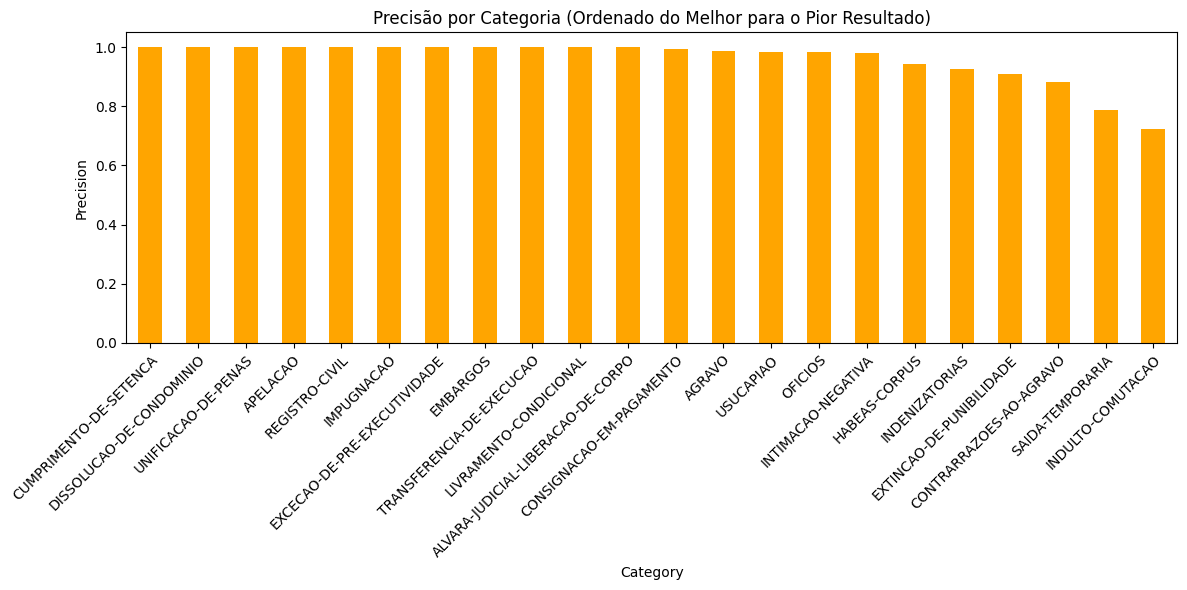

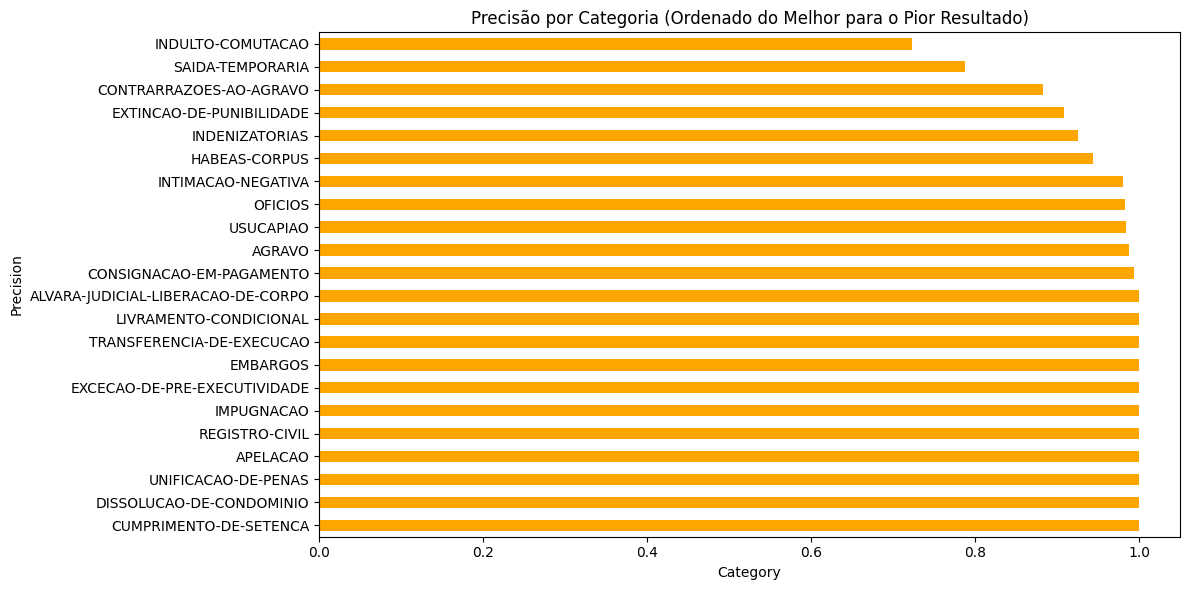

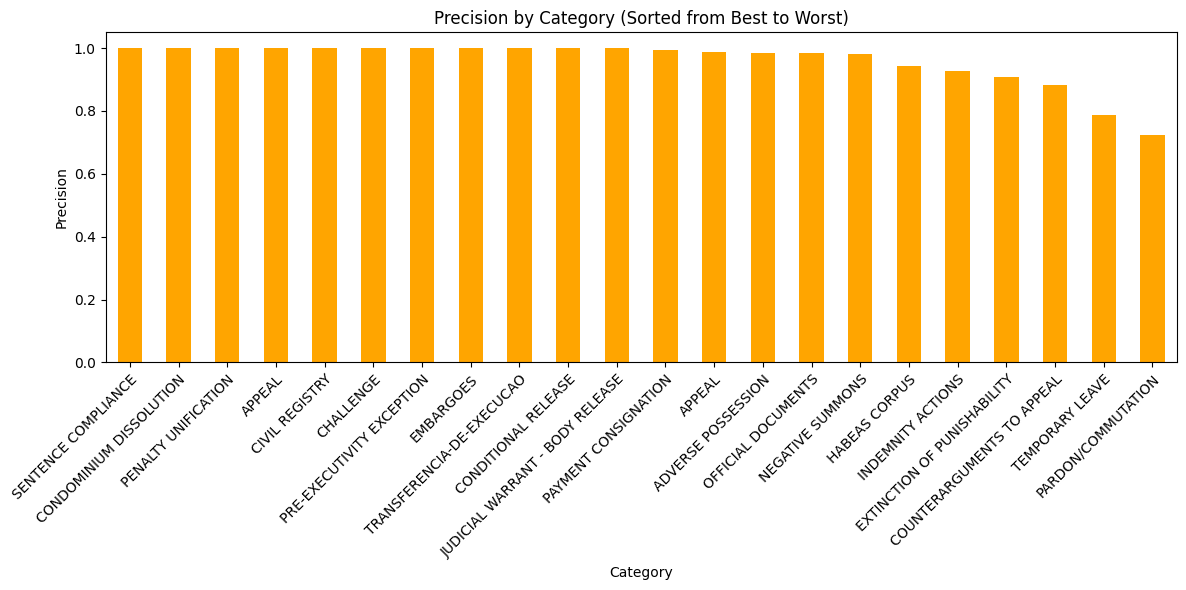

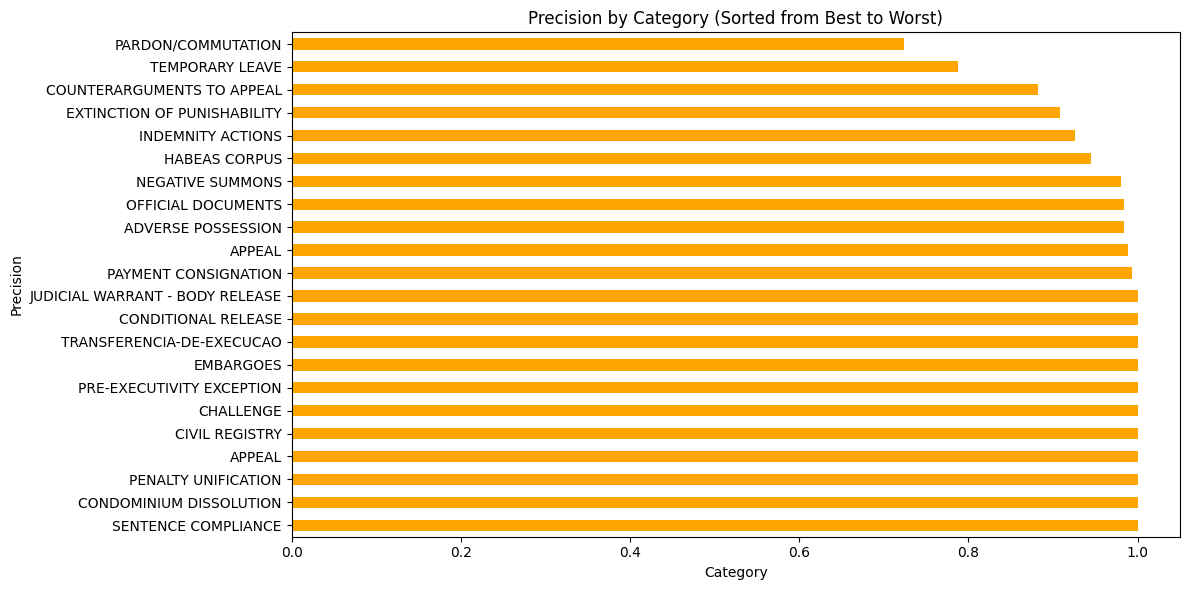

Normalized confusion matrix saved in CSV and Excel format.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from sklearn.metrics import confusion_matrix, classification_report

# Configurações iniciais
model_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Modelo-treinado-tokenizer-e-perdas-em-arquivos'
data_path = '/content/drive/MyDrive/Colab Notebooks/Defesa final/Dados DPE-GO/Dados-DPE-GO.xlsx - Dados-DPE-GO (1).csv'

# Carregar o modelo e o tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()
model.to('cuda')

# Carregar os dados
df = pd.read_csv(data_path)

# Mapear números de classes para nomes reais
class_names = {label: name for label, name in zip(df['issue_area_label'], df['issue_area'])}

# Listas para armazenar predições e categorias reais
predictions = []
real_categories = []

# Processar cada linha do DataFrame
for _, row in df.iterrows():
    text = row['facts']
    real_category = row['issue_area_label']

    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
    inputs = {key: value.to('cuda') for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits.cpu()
    predicted_class = torch.argmax(torch.softmax(logits, dim=1), dim=1).item()

    predictions.append(predicted_class)
    real_categories.append(real_category)

# Gerar a matriz de confusão e calcular métricas de desempenho
confusion_mat = confusion_matrix(real_categories, predictions)
report = classification_report(real_categories, predictions, target_names=list(class_names.values()), output_dict=True)

# Converter o relatório em um DataFrame e realizar ajustes
report_df = pd.DataFrame(report).transpose()

# Calcular a taxa de erro global
accuracy = report_df.loc['accuracy', 'precision']
error_rate = 1 - accuracy

# Selecionar métricas relevantes para o relatório consolidado
relevant_metrics = ['precision', 'recall', 'f1-score']
weighted_avg_metrics = report_df.loc['weighted avg', relevant_metrics].copy()
weighted_avg_metrics['error_rate'] = error_rate
weighted_avg_metrics['accuracy'] = accuracy

# Exibir métricas consolidadas
print("\nMétricas Consolidadas de Inferência do Modelo:")
print(weighted_avg_metrics)

# Ordenar as classes de acordo com a pontuação F1 do melhor para o pior
sorted_report_all = report_df.drop(['accuracy', 'macro avg', 'weighted avg']).sort_values(by='f1-score', ascending=False)

# Filtrar apenas as categorias com resultados
filtered_sorted_report = sorted_report_all[sorted_report_all['precision'] > 0]

# Exibir relatório de classificação por categoria
print("\nRelatório de Classificação por Categoria (Ordenado do Melhor para o Pior Resultado):")
print(filtered_sorted_report)

# Configurar opções de exibição do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

# Imprimir o relatório formatado
print("Matriz de Confusão:")
print(confusion_mat)

# Precisão total do modelo
total_precision = accuracy
print(f"\nPrecisão total do modelo: {total_precision:.2f}")

# Plotar gráficos de barras para a precisão de cada classe (formato ondulado)
def plot_precision_chart(data, title, color='skyblue', orientation='vertical'):
    data = data.sort_values(by='precision', ascending=False)
    plt.figure(figsize=(12, 6))
    if orientation == 'vertical':
        data['precision'].plot(kind='bar', color=color)
        plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    else:
        data['precision'].plot(kind='barh', color=color)
        plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Precision')
    plt.tight_layout()
    plt.show()

# Gráfico para todas as categorias com resultados (vertical)
plot_precision_chart(filtered_sorted_report, 'Precisão por Categoria (Ordenado do Melhor para o Pior Resultado)', color='orange', orientation='vertical')

# Gráfico para todas as categorias com resultados (horizontal)
plot_precision_chart(filtered_sorted_report, 'Precisão por Categoria (Ordenado do Melhor para o Pior Resultado)', color='orange', orientation='horizontal')

# Função para plotar gráficos com textos em inglês
def plot_precision_chart_english(data, title, color='skyblue', orientation='vertical'):
    category_mapping = {
        'CUMPRIMENTO-DE-SETENCA': 'SENTENCE COMPLIANCE',
        'IMPUGNACAO': 'CHALLENGE',
        'LIVRAMENTO-CONDICIONAL': 'CONDITIONAL RELEASE',
        'EXTINCAO-DE-PUNIBILIDADE': 'EXTINCTION OF PUNISHABILITY',
        'AGRAVO': 'APPEAL',
        'INDENIZATORIAS': 'INDEMNITY ACTIONS',
        'USUCAPIAO': 'ADVERSE POSSESSION',
        'REGISTRO-CIVIL': 'CIVIL REGISTRY',
        'EMBARGOS': 'EMBARGOES',
        'APELACAO': 'APPEAL',
        'INDULTO-COMUTACAO': 'PARDON/COMMUTATION',
        'OFICIOS': 'OFFICIAL DOCUMENTS',
        'EXCECAO-DE-PRE-EXECUTIVIDADE': 'PRE-EXECUTIVITY EXCEPTION',
        'TRANFERENCIA-DE-EXECUCAO': 'EXECUTION TRANSFER',
        'HABEAS-CORPUS': 'HABEAS CORPUS',
        'INTIMACAO-NEGATIVA': 'NEGATIVE SUMMONS',
        'DISSOLUCAO-DE-CONDOMINIO': 'CONDOMINIUM DISSOLUTION',
        'REMICAO-DE-PENA': 'REMISSION OF PENALTY',
        'PROGRESSAO-DE-REGIME': 'REGIME PROGRESSION',
        'CONSIGNACAO-EM-PAGAMENTO': 'PAYMENT CONSIGNATION',
        'CONTRARRAZOES-AO-AGRAVO': 'COUNTERARGUMENTS TO APPEAL',
        'ALVARA-JUDICIAL-LIBERACAO-DE-CORPO': 'JUDICIAL WARRANT - BODY RELEASE',
        'SAIDA-TEMPORARIA': 'TEMPORARY LEAVE',
        'UNIFICACAO-DE-PENAS': 'PENALTY UNIFICATION'
    }
    data = data.rename(index=category_mapping)
    data = data.sort_values(by='precision', ascending=False)
    plt.figure(figsize=(12, 6))
    if orientation == 'vertical':
        data['precision'].plot(kind='bar', color=color)
        plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    else:
        data['precision'].plot(kind='barh', color=color)
        plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Precision')
    plt.tight_layout()
    plt.show()

# Gráfico em inglês para todas as categorias com resultados (vertical)
plot_precision_chart_english(filtered_sorted_report, 'Precision by Category (Sorted from Best to Worst)', color='orange', orientation='vertical')

# Gráfico em inglês para todas as categorias com resultados (horizontal)
plot_precision_chart_english(filtered_sorted_report, 'Precision by Category (Sorted from Best to Worst)', color='orange', orientation='horizontal')

# Salvar relatórios e matriz de confusão em CSV
confusion_df = pd.DataFrame(confusion_mat, index=class_names.values(), columns=class_names.values())
confusion_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Inferência/confusion_matrix.csv')
filtered_sorted_report.to_csv('/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Inferência/classification_report_by_category.csv')
weighted_avg_metrics.to_frame().T.to_csv('/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Inferência/consolidated_metrics.csv')

# Calcular e salvar a matriz de confusão normalizada
confusion_normalized = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
confusion_normalized_df = pd.DataFrame(confusion_normalized, index=class_names.values(), columns=class_names.values())
confusion_normalized_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Inferência/normalized_confusion_matrix.csv')
confusion_normalized_df.to_excel('/content/drive/MyDrive/Colab Notebooks/Defesa final/BERTimbau Base/Inferência/normalized_confusion_matrix.xlsx')

print("Normalized confusion matrix saved in CSV and Excel format.")